In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multi-platform-social-sentiment-evolution/multi_platform_social_sentiment_evolution.csv
/kaggle/input/multi-platform-social-sentiment-evolution/README_social_sentiment.md
/kaggle/input/multi-platform-social-sentiment-evolution/column_descriptions_social_sentiment.md


In [16]:
import pandas as pd
import numpy as np
import re
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

EDA (Explanatory Data Analysis) 

In [17]:
DATA_PATH = "/kaggle/input/multi-platform-social-sentiment-evolution/multi_platform_social_sentiment_evolution.csv"
df = pd.read_csv(DATA_PATH)

# Preview the data
print("Shape:", df.shape)
print("Sample rows:")
display(df.head())

Shape: (150000, 31)
Sample rows:


,post_id,platform,timestamp,date,hour_of_day,day_of_week,is_weekend,user_id,followers,account_age_days,...,shares,comments,views,total_engagement,engagement_rate_per_1k_followers,hours_since_post,viral_coefficient,cross_platform_spread,toxicity_score,location
0,TIK20250419000000,TikTok,2025-04-19 01:56:55,2025-04-19,1,5,1,user_426711,137,306,...,0,0,0,0,0.00,37.1,0.00,0,29.4,Asia
1,TWI20250419000001,Twitter,2025-04-19 05:34:09,2025-04-19,5,5,1,user_221610,1974,2310,...,0,0,105,3,1.52,37.1,0.08,0,3.3,South America
2,INS20250419000002,Instagram,2025-04-19 06:33:36,2025-04-19,6,5,1,user_7998,6471,1990,...,0,0,26,2,0.31,21.0,0.10,0,25.3,Europe
3,INS20250419000003,Instagram,2025-04-19 06:42:16,2025-04-19,6,5,1,user_313440,1366,2057,...,16,8,3057,98,71.74,47.1,2.08,0,3.1,Europe
4,RED20250419000004,Reddit,2025-04-19 06:46:49,2025-04-19,6,5,1,user_23343,1349,1445,...,0,0,0,0,0.00,10.0,0.00,0,52.7,Asia


In [18]:
# Count rows with 0 likes and >0 likes for getting an estimate

zero_likes = (df['likes'] == 0).sum()
more_than_zero_likes = (df['likes'] > 0).sum()

print("Rows with 0 likes:", zero_likes)
print("Rows with >0 likes:", more_than_zero_likes)

Rows with 0 likes: 51053
Rows with >0 likes: 98947


In [19]:
# Get the first 20 tuple
df.head(20)

,post_id,platform,timestamp,date,hour_of_day,day_of_week,is_weekend,user_id,followers,account_age_days,...,shares,comments,views,total_engagement,engagement_rate_per_1k_followers,hours_since_post,viral_coefficient,cross_platform_spread,toxicity_score,location
0,TIK20250419000000,TikTok,2025-04-19 01:56:55,2025-04-19,1,5,1,user_426711,137,306,...,0,0,0,0,0.00,37.1,0.00,0,29.4,Asia
1,TWI20250419000001,Twitter,2025-04-19 05:34:09,2025-04-19,5,5,1,user_221610,1974,2310,...,0,0,105,3,1.52,37.1,0.08,0,3.3,South America
2,INS20250419000002,Instagram,2025-04-19 06:33:36,2025-04-19,6,5,1,user_7998,6471,1990,...,0,0,26,2,0.31,21.0,0.10,0,25.3,Europe
3,INS20250419000003,Instagram,2025-04-19 06:42:16,2025-04-19,6,5,1,user_313440,1366,2057,...,16,8,3057,98,71.74,47.1,2.08,0,3.1,Europe
4,RED20250419000004,Reddit,2025-04-19 06:46:49,2025-04-19,6,5,1,user_23343,1349,1445,...,0,0,0,0,0.00,10.0,0.00,0,52.7,Asia
5,RED20250419000005,Reddit,2025-04-19 07:55:21,2025-04-19,7,5,1,user_19777,124,1400,...,0,1,493,15,120.97,22.3,0.67,0,0.0,Asia
6,FAC20250419000006,Facebook,2025-04-19 08:04:37,2025-04-19,8,5,1,user_157662,265,57,...,0,0,0,0,0.00,12.0,0.00,0,23.0,North America
7,INS20250419000007,Instagram,2025-04-19 08:06:54,2025-04-19,8,5,1,user_146900,3433,3566,...,0,0,0,0,0.00,2.3,0.00,0,44.7,Asia
8,RED20250419000008,Reddit,2025-04-19 08:10:46,2025-04-19,8,5,1,user_432927,83,2490,...,0,0,13,1,12.05,33.2,0.03,0,0.0,Europe
9,INS20250419000009,Instagram,2025-04-19 08:13:38,2025-04-19,8,5,1,user_141932,18079,688,...,52,24,5359,551,30.48,40.8,13.52,0,6.4,Europe


In [20]:
# All the columns
df.columns.tolist()

['post_id',
 'platform',
 'timestamp',
 'date',
 'hour_of_day',
 'day_of_week',
 'is_weekend',
 'user_id',
 'followers',
 'account_age_days',
 'verified',
 'topic',
 'language',
 'content_length',
 'media_type',
 'num_hashtags',
 'sentiment_category',
 'sentiment_positive',
 'sentiment_negative',
 'sentiment_neutral',
 'likes',
 'shares',
 'comments',
 'views',
 'total_engagement',
 'engagement_rate_per_1k_followers',
 'hours_since_post',
 'viral_coefficient',
 'cross_platform_spread',
 'toxicity_score',
 'location']

In [21]:
# Show data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   post_id                           150000 non-null  object 
 1   platform                          150000 non-null  object 
 2   timestamp                         150000 non-null  object 
 3   date                              150000 non-null  object 
 4   hour_of_day                       150000 non-null  int64  
 5   day_of_week                       150000 non-null  int64  
 6   is_weekend                        150000 non-null  int64  
 7   user_id                           150000 non-null  object 
 8   followers                         150000 non-null  int64  
 9   account_age_days                  150000 non-null  int64  
 10  verified                          150000 non-null  int64  
 11  topic                             150000 non-null  o

In [22]:
# Check for missing values in each column
df.isnull().sum()

post_id                             0
platform                            0
timestamp                           0
date                                0
hour_of_day                         0
day_of_week                         0
is_weekend                          0
user_id                             0
followers                           0
account_age_days                    0
verified                            0
topic                               0
language                            0
content_length                      0
media_type                          0
num_hashtags                        0
sentiment_category                  0
sentiment_positive                  0
sentiment_negative                  0
sentiment_neutral                   0
likes                               0
shares                              0
comments                            0
views                               0
total_engagement                    0
engagement_rate_per_1k_followers    0
hours_since_

In [23]:
# Show descriptive statistics for numerical and categorical columns
df.describe(include="all")

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,post_id,platform,timestamp,date,hour_of_day,day_of_week,is_weekend,user_id,followers,account_age_days,...,shares,comments,views,total_engagement,engagement_rate_per_1k_followers,hours_since_post,viral_coefficient,cross_platform_spread,toxicity_score,location
count,150000,150000,150000,150000,150000.000000,150000.000000,150000.000000,150000,1.500000e+05,150000.000000,...,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000
unique,150000,6,148242,184,NaN,NaN,NaN,129556,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
top,FAC20251018149999,Twitter,2025-07-05 17:21:51,2025-09-22,NaN,NaN,NaN,user_283647,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,North America
freq,1,44676,3,4286,NaN,NaN,NaN,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52409
mean,NaN,NaN,NaN,NaN,16.647933,2.875440,0.276107,NaN,2.553545e+04,1842.492033,...,52.823820,30.179667,9.790219e+03,437.425913,57.274864,24.044388,55.553609,0.012973,23.813532,NaN
std,NaN,NaN,NaN,NaN,3.839549,2.038426,0.447072,NaN,6.501271e+05,1044.491836,...,406.558451,238.394866,7.608802e+04,3133.847108,321.476433,13.819392,1339.220297,0.113160,25.682093,NaN
min,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,NaN,0.000000e+00,30.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,14.000000,1.000000,0.000000,NaN,9.100000e+01,938.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,12.100000,0.000000,0.000000,1.075000,NaN
50%,NaN,NaN,NaN,NaN,17.000000,3.000000,0.000000,NaN,4.810000e+02,1848.000000,...,0.000000,0.000000,7.800000e+01,3.000000,4.180000,24.100000,0.170000,0.000000,14.800000,NaN
75%,NaN,NaN,NaN,NaN,20.000000,5.000000,1.000000,NaN,2.766250e+03,2746.000000,...,4.000000,2.000000,8.250000e+02,40.000000,27.030000,36.000000,2.390000,0.000000,38.500000,NaN


In [24]:
# Random 10 samples
df.sample(10)

,post_id,platform,timestamp,date,hour_of_day,day_of_week,is_weekend,user_id,followers,account_age_days,...,shares,comments,views,total_engagement,engagement_rate_per_1k_followers,hours_since_post,viral_coefficient,cross_platform_spread,toxicity_score,location
74907,FAC20250912074907,Facebook,2025-09-12 23:42:22,2025-09-12,23,4,0,user_369555,2690,2196,...,6,4,315,44,16.36,27.2,1.62,0,17.3,Asia
92570,TIK20250423092570,TikTok,2025-04-23 17:16:38,2025-04-23,17,2,0,user_129101,594,3138,...,0,0,13,1,1.68,24.8,0.04,0,83.6,North America
56662,RED20250810056662,Reddit,2025-08-10 15:02:58,2025-08-10,15,6,1,user_65118,19,3591,...,0,0,0,0,0.00,20.3,0.00,0,0.0,Asia
146832,TWI20251009146832,Twitter,2025-10-09 13:41:12,2025-10-09,13,3,0,user_63772,241,1845,...,0,0,137,4,16.60,13.8,0.29,0,0.0,Europe
91960,RED20250421091960,Reddit,2025-04-21 18:54:44,2025-04-21,18,0,0,user_430000,56,1963,...,0,0,0,0,0.00,6.1,0.00,0,0.0,South America
15420,INS20250519015420,Instagram,2025-05-19 18:36:13,2025-05-19,18,0,0,user_290029,136,1609,...,20,8,2589,123,904.41,3.1,39.26,0,0.0,North America
44173,TWI20250711044173,Twitter,2025-07-11 13:43:47,2025-07-11,13,4,0,user_411484,1152,590,...,0,0,32,1,0.87,34.7,0.03,0,32.0,North America
101876,FAC20250522101876,Facebook,2025-05-22 17:22:22,2025-05-22,17,3,0,user_274126,168,2164,...,2,0,461,12,71.43,37.5,0.32,0,0.0,North America
33599,TIK20250619033599,TikTok,2025-06-19 15:58:07,2025-06-19,15,3,0,user_452406,1228,3065,...,0,0,5,1,0.81,43.7,0.02,0,0.0,Europe
102650,RED20250524102650,Reddit,2025-05-24 20:27:09,2025-05-24,20,5,1,user_81554,3,1367,...,0,0,43,1,333.33,35.1,0.03,0,11.7,South America


In [25]:
# Get uniqie values in categorical columns
for col in ["platform", "language", "sentiment", "emotion", "topic", "hashtags"]:
    if col in df.columns:
        print(f"\nUnique values in {col}:")
        print(df[col].unique()[:50])



Unique values in platform:
['TikTok' 'Twitter' 'Instagram' 'Reddit' 'Facebook' 'YouTube']

Unique values in language:
['English' 'Spanish' 'French' 'Korean' 'German' 'Portuguese' 'Hindi'
 'Chinese' 'Arabic' 'Japanese']

Unique values in topic:
['Finance' 'Food' 'Sports' 'Education' 'Gaming' 'Climate' 'Business'
 'Travel' 'Fashion' 'Politics' 'Health' 'Entertainment' 'Science' 'AI/ML'
 'Technology']


In [26]:
# Sanity check for target variable
print("target mean:", df['engagement_rate_per_1k_followers'].mean())
print("target median:", df['engagement_rate_per_1k_followers'].median())
print("target min,max:", df['engagement_rate_per_1k_followers'].min(), df['engagement_rate_per_1k_followers'].max())

target mean: 57.2748642
target median: 4.18
target min,max: 0.0 28076.92


Training and Evaluating Multiple Models

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import joblib

# Configurations
TARGET = "engagement_rate_per_1k_followers"
CATEGORICAL = ["platform", "media_type", "location", "topic", "language"]

# features to be trained on
FEATURES = [
    "platform", 
    "followers", 
    "account_age_days", 
    "verified",
    "media_type",
    "location",
    "topic",
    "language",
    "content_length",
    "num_hashtags",
    "sentiment_positive",
    "sentiment_negative",
    "sentiment_neutral",
    "toxicity_score",
    "day_of_week",
    "hour_of_day",
    "cross_platform_spread"
]

X = df[FEATURES]
y = df[TARGET]

NUMERIC = [c for c in FEATURES if c not in CATEGORICAL]

# Preprocessing pipeline - one-hot encode categorical, passthrough numeric
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL),
    ("num", "passthrough", NUMERIC)
])

# Three different models to try
models = {
    "XGBoost": XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror"
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=-1,
        num_leaves=64
    ),
    "CatBoost": CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=10,
        verbose=0
    )
}

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# To track the best model (RMSE is the metric)
best_rmse = float("inf")
best_model = None
best_name = None

# Train and evaluate each model
for name, model_obj in models.items():

    print("\nTraining:", name)

    pipeline = Pipeline([
        ("prep", preprocessor),
        ("model", model_obj)
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    print(f"{name} RMSE: {rmse:.3f}, R2: {r2:.3f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_name = name
        best_model = pipeline

print("\nBest Model:", best_name, "| RMSE:", best_rmse)

# Feature Importance using Permutation Importance

print("\nCalculating permutation feature importance...")

perm = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42
)

importance_df = pd.DataFrame({
    "feature": FEATURES,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

print("\nFeature Importance:\n", importance_df)

importance_df.to_csv("feature_importance.csv", index=False)
print("Saved feature importance → feature_importance.csv")

# Save the best model
joblib.dump(best_model, "best_time_model.pkl")
print("\nModel saved as best_time_model.pkl")


Training: XGBoost
XGBoost RMSE: 318.269, R2: -0.040

Training: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1916
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 55
[LightGBM] [Info] Start training from score 57.359748
LightGBM RMSE: 310.233, R2: 0.012

Training: CatBoost
CatBoost RMSE: 310.463, R2: 0.011

Best Model: LightGBM | RMSE: 310.23310123181056

Calculating permutation feature importance...

Feature Importance:
                   feature  importance
16  cross_platform_spread    0.353648
1               followers    0.239354
13         toxicity_score    0.107989
11     sentiment_negative    0.073740
10     sentiment_positive    0.053238
12      sentiment_neutral    0.042168
2        account_age_days    0.003516
6        

Inference with the Best Model and NLP Features

In [38]:
import random
import joblib
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")


# -----------------------------
# Topic synthetic keywords
# -----------------------------
TOPIC_KEYWORDS = {
    "Finance": ["stock", "market", "investment", "crypto", "bank"],
    "Food": ["food", "recipe", "restaurant", "delicious", "dinner"],
    "Sports": ["match", "football", "cricket", "goal", "tournament"],
    "Education": ["study", "exam", "college", "lecture", "homework"],
    "Gaming": ["game", "gaming", "console", "level", "stream"],
    "Climate": ["climate", "pollution", "global warming", "sustainability"],
    "Business": ["startup", "founder", "entrepreneur", "revenue"],
    "Travel": ["travel", "trip", "vacation", "flight", "hotel"],
    "Fashion": ["style", "outfit", "fashion", "wardrobe"],
    "Politics": ["election", "government", "policy", "vote"],
    "Health": ["health", "fitness", "workout", "diet"],
    "Entertainment": ["movie", "music", "show", "concert"],
    "Science": ["research", "experiment", "lab", "discovery"],
    "AI/ML": ["model", "ai", "ml", "neural", "dataset"],
    "Technology": ["tech", "software", "device", "smartphone"]
}

# -----------------------------
# Improved Template Sets
# -----------------------------

POSITIVE_TEMPLATES = [
    "I absolutely love {kw}!",
    "This {kw} made my day amazing!",
    "Feeling great about {kw} today.",
    "What an incredible {kw} experience!",
    "Super happy with the latest {kw} updates.",
]

NEGATIVE_TEMPLATES = [
    "I hate {kw}, terrible experience.",
    "The {kw} today was awful and disappointing.",
    "{kw} really pissed me off today.",
    "Worst {kw} I've ever seen.",
    "Totally unhappy with how {kw} turned out.",
]

NEUTRAL_TEMPLATES = [
    "{kw} happened today.",
    "General update about {kw}.",
    "Here are my thoughts on {kw}.",
    "Some news related to {kw}.",
    "{kw} is neither good nor bad today.",
]

TOXIC_TEMPLATES = [
    "{kw} is stupid and pathetic.",
    "Only an idiot would like {kw}.",
    "{kw} is trash, absolutely dumb.",
    "Whoever likes {kw} is a loser.",
    "{kw} is disgusting and horrible.",
]

ALL_TEMPLATES = POSITIVE_TEMPLATES + NEGATIVE_TEMPLATES + NEUTRAL_TEMPLATES + TOXIC_TEMPLATES

TOXIC_WORDS = [
    "hate", "stupid", "idiot", "dumb", "kill",
    "trash", "loser", "nonsense", "racist", "sexist", "ugly",
]


# -----------------------------
# Generate Improved Synthetic Captions
# -----------------------------
def generate_synthetic(n_per_topic=800):
    captions = []
    topics = []

    for topic, kws in TOPIC_KEYWORDS.items():
        for _ in range(n_per_topic):
            kw = random.choice(kws)

            # Balanced sentiment & toxicity generation
            rnd = random.random()

            if rnd < 0.25:
                tmpl = random.choice(POSITIVE_TEMPLATES)
            elif rnd < 0.50:
                tmpl = random.choice(NEGATIVE_TEMPLATES)
            elif rnd < 0.75:
                tmpl = random.choice(NEUTRAL_TEMPLATES)
            else:
                tmpl = random.choice(TOXIC_TEMPLATES)

            text = tmpl.format(kw=kw)

            # Sarcasm injector
            if random.random() < 0.10:
                text += " Yeah right."

            # Hashtags
            if random.random() < 0.20:
                text += " #update #news"

            captions.append(text)
            topics.append(topic)

    return pd.DataFrame({"caption": captions, "topic": topics})


# -----------------------------
# Auto labeling sentiment/toxicity
# -----------------------------
sia = SentimentIntensityAnalyzer()

def vader_label(text):
    score = sia.polarity_scores(text)["compound"]
    if score >= 0.05: return "positive"
    if score <= -0.05: return "negative"
    return "neutral"

def toxicity_label(text):
    t = text.lower()
    toxicity_strength = sum(t.count(w) for w in TOXIC_WORDS)

    # Boost strong toxic triggers
    if any(w in t for w in ["idiot", "pathetic", "trash", "loser"]):
        toxicity_strength += 2

    return 1 if toxicity_strength >= 1 else 0


# -----------------------------
# Train and Save Models
# -----------------------------
def build_and_save_models():
    print("Generating improved synthetic captions...")
    df = generate_synthetic()

    print("Auto-labeling sentiment and toxicity...")
    df["sentiment"] = df["caption"].apply(vader_label)
    df["toxicity"] = df["caption"].apply(toxicity_label)

    print("Vectorizing text...")
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=15000)
    X = vectorizer.fit_transform(df["caption"])

    # ---- Topic model ----
    print("\nTraining Topic Model...")
    y_topic = df["topic"]
    Xtr, Xte, ytr, yte = train_test_split(X, y_topic, test_size=0.2)
    topic_clf = LogisticRegression(max_iter=3000, multi_class="multinomial")
    topic_clf.fit(Xtr, ytr)
    print(classification_report(yte, topic_clf.predict(Xte)))

    # ---- Sentiment model ----
    print("\nTraining Sentiment Model...")
    y_sent = df["sentiment"]
    Xtr, Xte, ytr, yte = train_test_split(X, y_sent, test_size=0.2)
    sent_clf = LogisticRegression(max_iter=3000, multi_class="multinomial")
    sent_clf.fit(Xtr, ytr)
    print(classification_report(yte, sent_clf.predict(Xte)))

    # ---- Toxicity model ----
    print("\nTraining Toxicity Model...")
    y_tox = df["toxicity"]
    Xtr, Xte, ytr, yte = train_test_split(X, y_tox, test_size=0.2)
    tox_clf = LogisticRegression(max_iter=3000)
    tox_clf.fit(Xtr, ytr)
    print(classification_report(yte, tox_clf.predict(Xte)))

    # ---- Save models ----
    Path("models").mkdir(exist_ok=True)

    joblib.dump(vectorizer, "models/vectorizer.joblib")
    joblib.dump(topic_clf, "models/topic_model.joblib")
    joblib.dump(sent_clf, "models/sentiment_model.joblib")
    joblib.dump(tox_clf, "models/toxicity_model.joblib")

    print("\n🎉 Improved models saved in ./models/")
    print("vectorizer.joblib")
    print("topic_model.joblib")
    print("sentiment_model.joblib")
    print("toxicity_model.joblib")


if __name__ == "__main__":
    build_and_save_models()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Generating improved synthetic captions...
Auto-labeling sentiment and toxicity...
Vectorizing text...

Training Topic Model...
               precision    recall  f1-score   support

        AI/ML       1.00      1.00      1.00       153
     Business       1.00      1.00      1.00       149
      Climate       1.00      1.00      1.00       174
    Education       1.00      1.00      1.00       134
Entertainment       1.00      1.00      1.00       156
      Fashion       1.00      1.00      1.00       157
      Finance       1.00      1.00      1.00       150
         Food       1.00      1.00      1.00       175
       Gaming       1.00      1.00      1.00       170
       Health       1.00      1.00      1.00       171
     Politics       1.00      1.00      1.00       182
      Science       1.00      1.00      1.00       160
       Sports       1.00      1.00      1.00       157
   Technology       1.00      1.00      1.00       147
       Travel       1.00      1.00      1.00   

In [39]:
import joblib

# Load models
vectorizer = joblib.load("models/vectorizer.joblib")
topic_model = joblib.load("models/topic_model.joblib")
sentiment_model = joblib.load("models/sentiment_model.joblib")
toxicity_model = joblib.load("models/toxicity_model.joblib")

def test_prediction(caption):
    # Convert caption to vector
    X = vectorizer.transform([caption])

    # ----- Topic Prediction -----
    topic_pred = topic_model.predict(X)[0]

    # ----- Sentiment Prediction -----
    sent_pred = sentiment_model.predict(X)[0]
    if hasattr(sentiment_model, "predict_proba"):
        sent_probs = sentiment_model.predict_proba(X)[0]
        classes = sentiment_model.classes_
        sent_prob_map = {cls: float(sent_probs[i]) for i, cls in enumerate(classes)}
    else:
        sent_prob_map = {}

    # ----- Toxicity Prediction -----
    if hasattr(toxicity_model, "predict_proba"):
        tox_prob = float(toxicity_model.predict_proba(X)[0][1])
    else:
        tox_prob = float(toxicity_model.predict(X)[0])

    print("\n---------------------------------------")
    print(f"Input Caption: {caption}")
    print("---------------------------------------")
    print(f"Topic Prediction      : {topic_pred}")
    print(f"Sentiment Prediction  : {sent_pred}")
    print(f"Sentiment Probabilities: {sent_prob_map}")
    print(f"Toxicity Score (0–1)  : {tox_prob}")
    print("---------------------------------------\n")


# ------------------------
# TEST EXAMPLES
# ------------------------

test_prediction("I love the new iPhone, amazing device!")
test_prediction("The stock market crashed badly today.")
test_prediction("This restaurant food is horrible and stupid.")
test_prediction("Going on a trip next week! #travel")



---------------------------------------
Input Caption: I love the new iPhone, amazing device!
---------------------------------------
Topic Prediction      : Technology
Sentiment Prediction  : positive
Sentiment Probabilities: {'negative': 0.0316553984769678, 'neutral': 0.009248745305745766, 'positive': 0.9590958562172863}
Toxicity Score (0–1)  : 0.007346090018559116
---------------------------------------


---------------------------------------
Input Caption: The stock market crashed badly today.
---------------------------------------
Topic Prediction      : Finance
Sentiment Prediction  : negative
Sentiment Probabilities: {'negative': 0.6935328713708455, 'neutral': 0.14198846178524502, 'positive': 0.1644786668439095}
Toxicity Score (0–1)  : 0.024731370699616492
---------------------------------------


---------------------------------------
Input Caption: This restaurant food is horrible and stupid.
---------------------------------------
Topic Prediction      : Food
Sentiment P

In [40]:
!pip install langdetect

In [41]:
import joblib
import pandas as pd
import numpy as np
import re
from langdetect import detect

# -----------------------------
# Load main engagement model
# -----------------------------
model = joblib.load("best_time_model.pkl")

# -----------------------------
# Load lightweight NLP models
# -----------------------------
VEC = joblib.load("models/vectorizer.joblib")
TOPIC_MODEL = joblib.load("models/topic_model.joblib")
SENTIMENT_MODEL = joblib.load("models/sentiment_model.joblib")
TOXICITY_MODEL = joblib.load("models/toxicity_model.joblib")

TOPIC_OPTIONS = TOPIC_MODEL.classes_   # maintains compatibility


# ----------------------------------------------------------
#  REPLACEMENT FOR infer_topic()  (same signature & output)
# ----------------------------------------------------------

def infer_topic(caption):
    X = VEC.transform([caption])
    pred = TOPIC_MODEL.predict(X)[0]
    return pred   # EXACT same return type as before


# ----------------------------------------------------------
#  REPLACEMENT FOR infer_language()  (simple lightweight)
# ----------------------------------------------------------

def infer_language(caption):
    try:
        lang = detect(caption)
        return lang.lower()
    except:
        return "unknown"


# ----------------------------------------------------------
#  REPLACEMENT FOR infer_sentiment()  (same dict output)
# ----------------------------------------------------------

def infer_sentiment(caption):
    X = VEC.transform([caption])
    pred = SENTIMENT_MODEL.predict(X)[0]

    # get probabilities if model supports it
    if hasattr(SENTIMENT_MODEL, "predict_proba"):
        proba = SENTIMENT_MODEL.predict_proba(X)[0]
        classes = SENTIMENT_MODEL.classes_
        prob_map = {cls: float(proba[i]) for i, cls in enumerate(classes)}
    else:
        prob_map = {"positive": 0.0, "negative": 0.0, "neutral": 0.0}
        prob_map[pred] = 1.0

    return {
        "pos": prob_map.get("positive", 0.0),
        "neg": prob_map.get("negative", 0.0),
        "neu": prob_map.get("neutral", 0.0),
        "label": pred
    }


# ----------------------------------------------------------
#  REPLACEMENT FOR infer_toxicity()  (returns float toxicity)
# ----------------------------------------------------------

def infer_toxicity(caption):
    X = VEC.transform([caption])
    if hasattr(TOXICITY_MODEL, "predict_proba"):
        prob = TOXICITY_MODEL.predict_proba(X)[0][1]
        return float(prob)
    return float(TOXICITY_MODEL.predict(X)[0])


# ----------------------------------------------------------
# Utilities (unchanged)
# ----------------------------------------------------------

def get_content_length(caption):
    return len(caption)

def get_num_hashtags(caption):
    return len(re.findall(r"#\w+", caption))


# ----------------------------------------------------------
# Extract Caption Features (same structure as original)
# ----------------------------------------------------------

def extract_caption_features(caption):
    topic = infer_topic(caption)
    language = infer_language(caption)
    sentiment = infer_sentiment(caption)
    toxicity = infer_toxicity(caption)

    return {
        "topic": topic,
        "language": language,
        "content_length": get_content_length(caption),
        "num_hashtags": get_num_hashtags(caption),

        "sentiment_positive": sentiment["pos"],
        "sentiment_negative": sentiment["neg"],
        "sentiment_neutral": sentiment["neu"],
        "sentiment_category": sentiment["label"],

        "toxicity_score": toxicity
    }


# ----------------------------------------------------------
# SAME FUNCTION YOU ALREADY HAVE — UNCHANGED
# ----------------------------------------------------------

def predict_best_time(platform, followers, account_age_days, verified,
                      media_type, location, caption, cross_platform_spread):

    cap = extract_caption_features(caption)
    rows = []

    for day in range(7):
        for hour in range(24):
            row = {
                "platform": platform,
                "followers": followers,
                "account_age_days": account_age_days,
                "verified": verified,
                "media_type": media_type,
                "location": location,
                "cross_platform_spread": cross_platform_spread,
                "day_of_week": day,
                "hour_of_day": hour,
                **cap
            }
            rows.append(row)

    df_pred = pd.DataFrame(rows)
    df_pred["predicted_engagement"] = model.predict(df_pred)

    best_row = df_pred.loc[df_pred["predicted_engagement"].idxmax()]

    return (
        int(best_row["day_of_week"]),
        int(best_row["hour_of_day"]),
        float(best_row["predicted_engagement"])
    )


Testing the Model with HeatMap Analysis

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

def get_day_hour_heatmap(platform, followers, account_age_days, verified,
                         media_type, location, caption, cross_platform_spread):

    # --- Get all predictions ---
    cap = extract_caption_features(caption)
    rows = []

    for day in range(7):
        for hour in range(24):
            row = {
                "platform": platform,
                "followers": followers,
                "account_age_days": account_age_days,
                "verified": verified,
                "media_type": media_type,
                "location": location,
                "cross_platform_spread": cross_platform_spread,
                "day_of_week": day,
                "hour_of_day": hour,
                **cap
            }
            rows.append(row)

    df_pred = pd.DataFrame(rows)
    df_pred["predicted_engagement"] = model.predict(df_pred)

    # --- Create pivot table ---
    heatmap_data = df_pred.pivot_table(
        index="day_of_week",
        columns="hour_of_day",
        values="predicted_engagement"
    )

    # --- Plot heatmap ---
    plt.figure(figsize=(16, 6))
    plt.imshow(heatmap_data, aspect="auto")
    plt.colorbar(label="Predicted Engagement Rate per 1k Followers")
    plt.title("Engagement Heatmap by Day & Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.xticks(range(24), range(24))
    plt.yticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
    plt.show()

    return heatmap_data,df_pred


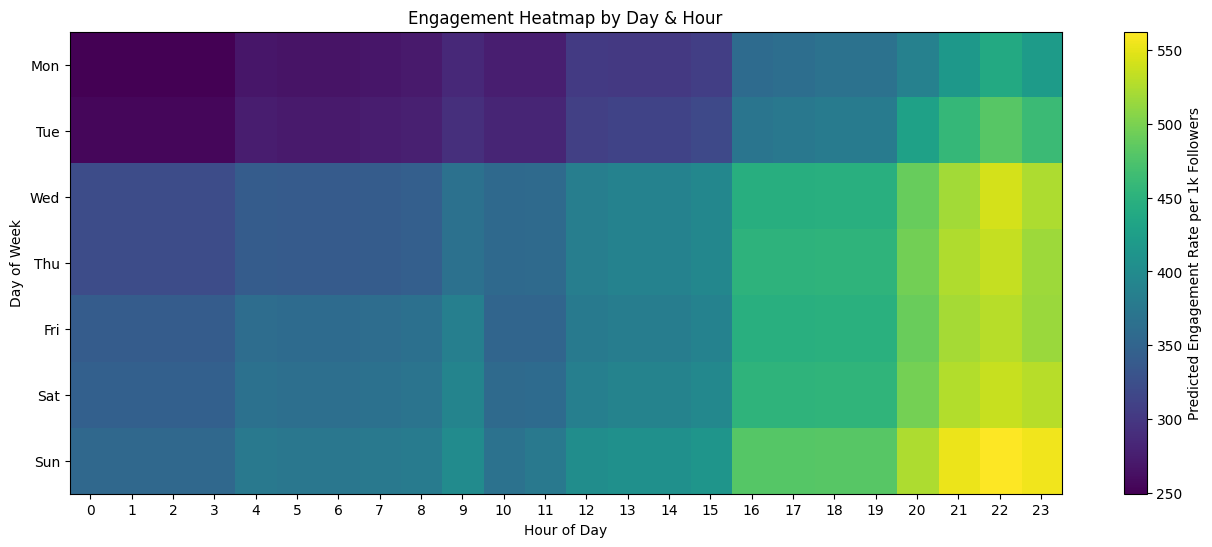

day_of_week                      6
hour_of_day                     22
predicted_engagement    562.249115
Name: 166, dtype: object


In [43]:
heatmap, df_pred = get_day_hour_heatmap( platform="Instagram",
    followers=12000,
    account_age_days=800,
    verified=0,
    media_type="image",
    location="North America",
    caption="Excited to share my AI project today! #AI #ML",
    cross_platform_spread=1)

best_index = df_pred["predicted_engagement"].idxmax()
print(df_pred.loc[best_index][["day_of_week","hour_of_day","predicted_engagement"]])


In [44]:
best_index = df_pred["predicted_engagement"].idxmax()
print(df_pred.loc[best_index][["day_of_week","hour_of_day","predicted_engagement"]])


day_of_week                      6
hour_of_day                     22
predicted_engagement    562.249115
Name: 166, dtype: object


In [45]:
best_day, best_hour, engagement = predict_best_time(
    platform="Instagram",
    followers=12000,
    account_age_days=800,
    verified=0,
    media_type="image",
    location="North America",
    caption="Excited to share my AI project today! #AI #ML",
    cross_platform_spread=1
)

print("Best Day:", best_day)
print("Best Hour:", best_hour)
print("Expected Engagement:", engagement)


Best Day: 6
Best Hour: 22
Expected Engagement: 562.249114527352
